In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from IPython.display import display, clear_output

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import pyro.poutine as poutine

from datasets import load_dataset

pyro.set_rng_seed(1)
pyro.clear_param_store()

In [2]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import logging
logging.set_verbosity_error()


ds = load_dataset("armanc/pubmed-rct20k")

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
print(ds)

# one row 
print(ds["train"][0])

DatasetDict({
    train: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 176642
    })
    validation: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 29672
    })
    test: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 29578
    })
})
{'abstract_id': '24293578', 'label': 'objective', 'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'sentence_id': 0}


In [5]:
ds.keys()

dict_keys(['train', 'validation', 'test'])

In [6]:
train_df = ds["train"].to_pandas()

# Recombine into full abstracts
abstracts = (
    train_df.sort_values(["abstract_id", "sentence_id"])
    .groupby("abstract_id")["text"]
    .apply(lambda s: " ".join(s))
    .reset_index()
)

print(abstracts.head())
print(f"Reconstructed {len(abstracts)} abstracts from {len(train_df)} sentences")

  abstract_id                                               text
0    24219770  The purpose of this study was to determine the...
1    24219814  Repeated courses of intravenous ( IV ) aminogl...
2    24219842  To determine whether the Pediatric Asthma Cont...
3    24219852  Despite the benefits of endoscopic nasobiliary...
4    24219882  We assessed the impact of hot flashes and vari...
Reconstructed 15000 abstracts from 176642 sentences


In [7]:
# 1) Sample abstracts (e.g., 3000) after recombining
sampled_abs = abstracts.sample(n=300, random_state=42).reset_index(drop=True)

# 2) Save the selected IDs (so you can re-run exactly)
sel_ids = sampled_abs["abstract_id"].astype(str)


# 3) (Optional) also subset the original sentence-level split for later use
train_df_small = train_df[train_df["abstract_id"].astype(str).isin(sel_ids)]

abstracts = sampled_abs

print(abstracts.head())
print(f" {len(abstracts)} ")

  abstract_id                                               text
0    25416486  Patient centred and individually-tailored coun...
1    24845394  The steady-state pharmacokinetics of two doses...
2    25651741  NT-pro-BNP level is increased in both systolic...
3    24300949  This study aims to determine the long-term eff...
4    24794277  The aim of this trial was to compare the rates...
 300 


In [8]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords & short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nedamohseni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
tokenized = [preprocess(abs) for abs in abstracts["text"]]

In [91]:
from collections import Counter

all_words = [w for doc in tokenized for w in doc]
counts = Counter(all_words)

vocab_size = 200   # was 20000
vocab_list = [w for w, _ in counts.most_common(vocab_size)]
vocab = {w: i for i, w in enumerate(vocab_list)}
i2word = {i: w for w, i in vocab.items()}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 200


{'patients': 0,
 'group': 1,
 'treatment': 2,
 'study': 3,
 'groups': 4,
 'randomized': 5,
 'rsb': 6,
 'placebo': 7,
 'significant': 8,
 'lsb': 9,
 'trial': 10,
 'compared': 11,
 'significantly': 12,
 'control': 13,
 'intervention': 14,
 'months': 15,
 'baseline': 16,
 'participants': 17,
 'weeks': 18,
 'therapy': 19,
 'time': 20,
 'clinical': 21,
 'using': 22,
 'years': 23,
 'mean': 24,
 'week': 25,
 'pain': 26,
 'primary': 27,
 'risk': 28,
 'dose': 29,
 'increased': 30,
 'two': 31,
 'received': 32,
 'difference': 33,
 'associated': 34,
 'efficacy': 35,
 'controlled': 36,
 'one': 37,
 'effect': 38,
 'based': 39,
 'high': 40,
 'age': 41,
 'respectively': 42,
 'levels': 43,
 'may': 44,
 'care': 45,
 'total': 46,
 'follow': 47,
 'children': 48,
 'effects': 49,
 'outcomes': 50,
 'health': 51,
 'women': 52,
 'rate': 53,
 'day': 54,
 'disease': 55,
 'days': 56,
 'cancer': 57,
 'assessed': 58,
 'patient': 59,
 'analysis': 60,
 'higher': 61,
 'change': 62,
 'weight': 63,
 'randomly': 64,
 'ye

In [ ]:
#####  not sure what this does 

In [101]:
# 1) Build a stoplist and find their IDs
stop = {
    "patients","patient","group","groups","treatment","treated","study","studies",
    "randomized","randomised","trial","control","controlled","placebo","compared","comparison",
    "significant","significantly","outcome","outcomes","baseline","participants",
    "month","months","week","weeks","year","years","day","days","time",
    "difference","differences","received","dose","effect","effects","primary","follow","follow-up",
    "random","randomly","versus","respectively","data","used","using","analysis","results",
    "evaluate","assessed","quality","safety","events","reduction", "lsb","rsb"
}
stop_ids = {vocab[w] for w in stop if w in vocab}

# 2) Compute document frequency
df = (X > 0).sum(axis=0)              # shape (W,)
df = df.A1 if hasattr(df, "A1") else df  # handle sparse/dense
too_common = set(map(int, (df >= 0.30 * D).nonzero()[0]))
too_rare   = set(map(int, (df < 15).nonzero()[0]))

# 3) Build drop set
drop = stop_ids | too_common | too_rare

# 4) Remap word indices and filter tokens
keep = sorted(set(range(W)) - drop)
old2new = -1 * np.ones(W, dtype=int)
old2new[keep] = np.arange(len(keep))

mask = np.isin(words, keep)
words = old2new[words[mask]]
docs  = docs[mask]
W = len(keep)

# (No need to rebuild X for Gibbs; use words/docs. Rebuild vocab maps if you print words:)
i2word = {new: i2word_old for new, i2word_old in enumerate([i2word[k] for k in keep])}

In [105]:
words = []
docs = []

for doc_id, doc in enumerate(tokenized):
    for w in doc:
        if w in vocab:
            words.append(vocab[w])
            docs.append(doc_id)

import numpy as np
words = np.array(words, dtype=int)
docs = np.array(docs, dtype=int)

D = max(docs) + 1
W = max(words) + 1
N = len(docs)

print(f"#docs={D}, vocab size={W}, total tokens={N}")

#docs=300, vocab size=200, total tokens=17447


In [107]:
X = np.zeros((D, W), dtype=int)
for di, wi in zip(docs, words):
    X[di, wi] += 1

In [109]:
# Top-K most frequent words across the whole corpus
K = 100
tf = X.sum(axis=0)                 # term frequencies, shape (W,)
order = np.argsort(-tf)            # descending
top = [(i2word[i], int(tf[i])) for i in order[:K]]
for w, c in top:
    print(f"{w}\t{c}")

intervention	703
therapy	663
mean	364
pain	360
risk	248
increased	236
two	216
associated	213
efficacy	213
one	213
based	211
high	202
age	201
levels	189
may	186
care	167
total	161
children	159
health	156
women	153
rate	153
disease	143
cancer	136
higher	133
change	129
weight	126
reported	125
first	125
among	125
low	121
adverse	121
subjects	120
test	117
use	115
however	115
assigned	112
either	110
life	110
score	106
blood	104
scores	104
lower	103
observed	103
also	103
effective	102
without	100
surgery	99
response	99
statistically	98
physical	97
ratio	97
receive	96
standard	95
included	94
period	93
performed	91
self	88
non	88
similar	87
pressure	86
decreased	86
level	86
measured	86
double	85
function	83
less	82
symptoms	81
conducted	80
loss	80
related	79
changes	78
blind	78
interval	77
median	77
per	76
rates	76
three	75
post	75
activity	75
daily	74
reduced	74
hours	73
index	72
factors	71
number	70
postoperative	70
following	70
diabetes	70
greater	70
well	69
alone	69
evaluated	69
overall	69


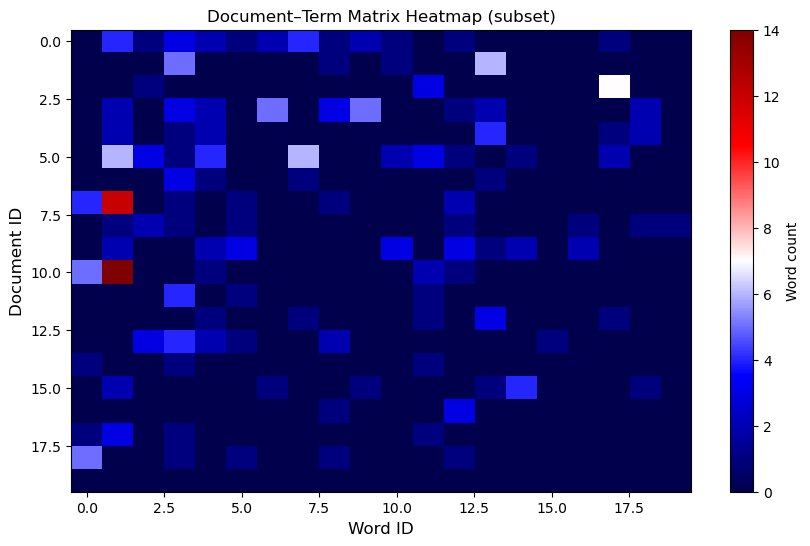

In [111]:
plt.figure(figsize=(10,6))
plt.xlabel("Word ID", fontsize=12)
plt.ylabel("Document ID", fontsize=12)

# For big vocab, plotting everything is overwhelming.
# So let's just look at the first 20 docs × first 20 words:
plt.imshow(X[:20, :20], aspect="auto", cmap="seismic")
plt.colorbar(label="Word count")
plt.title("Document–Term Matrix Heatmap (subset)")
plt.show()

In [113]:
# Initialize our latent assignments Z and set up per-X-topic arrays to keep track of assignment totals

np.random.seed(0)

T = 5        # Only two topics ("HCI" and "Graph theory")
beta = .01     # LDA parameters: control sparsity of documents & topics
alpha = .001

a = np.zeros((D,T),dtype=int)   # total times a token in document d has been assigned to topic t
b = np.zeros((W,T),dtype=int)   # total times word w has been assigned to topic t
c = np.zeros((T,),dtype=int)    # total assignments to topic t

z = np.random.randint(T,size=N);  # assign every token to a topic at random
for n in range(N):
    a[docs[n],z[n]] += 1             # and each document ID
    b[words[n],z[n]] += 1             # count up number for each word ID
    c[z[n]] += 1

In [115]:
def gibbs_collapsed(maxIter):
    for it in range(maxIter):             # for each iteration 
        print(it)
        for i in range(N):                # run through all the words & sample z[i]:
            t = z[i];
            a[docs[i],t] -= 1                # remove token i's assignment from our count vectors
            b[words[i],t] -= 1            
            c[t]      -= 1

            # Compute topic probability distribution given current counts
            probs = (beta + b[words[i],:])/(c[:] + beta*W) * (alpha + a[docs[i],:])

            # Now, normalize and draw a sample from the distribution over topics:
            cumprobs = np.cumsum(probs); cumprobs /= cumprobs[-1] 
            t = np.where(cumprobs>np.random.rand())[0][0]

            z[i] = t;                      # now add this assignment back into our count vectors
            a[docs[i],t] += 1
            b[words[i],t] += 1
            c[t]      += 1

In [117]:
# Helper function for visualizing the learning process
def print_topics():
    '''Print the top 8 words in each topic given the current assignments'''
    for t in range(T):
        isort = np.argsort(-b[:,t])  # find the most likely words for topic t
        xsort = b[isort,t]           # then print topic, % tokens explained, & top 8 words
        print('[{}] ({:.3f}) {}'.format(t, 1.*c[t]/N, list(i2word[isort[ww]] for ww in range(8) if xsort[ww]>0)))

In [119]:
print_topics();       # before running any iterations: random assignment

[0] (0.198) ['therapy', 'intervention', 'mean', 'pain', 'high', 'based', 'associated', 'two']
[1] (0.200) ['intervention', 'therapy', 'mean', 'pain', 'risk', 'increased', 'one', 'two']
[2] (0.198) ['intervention', 'therapy', 'pain', 'mean', 'risk', 'two', 'high', 'efficacy']
[3] (0.204) ['intervention', 'therapy', 'mean', 'pain', 'risk', 'increased', 'associated', 'age']
[4] (0.200) ['intervention', 'therapy', 'pain', 'mean', 'efficacy', 'one', 'total', 'increased']


In [121]:
gibbs_collapsed(400)            # run a bunch of iterations
print_topics();

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27